# CAB420, Metric Learning, Example 2: Contrastive Loss
Dr Simon Denman (s.denman@qut.edu.au)

## Overview
In this example we will continue our exploration of Siamese networks. Our first Siamese Network used binary cross entropy. This worked ok for telling us if things were the same, or different, but didn't really say how similar or how different things are. Often in machine learning, we'd like to rank things by similarity. For example, consider a biometrics scenario. We might want to find a suspect in CCTV, but rather than check if each and every person is the one we're after, it makes more sense to return the best $N$ matches. However to do this, we need a way to quantify how similar things are. This is where contrastive loss comes in.

This example is going to repeat a fair bit of code from the CAB420_Metric_Learning_Ex1_SiameseNetworks demo, so if you haven't looked at that example, please do so before diving into this one.

## Too Long; Didn't Read:
* Contrastive loss allows us to specify how much closer similar pairs of images should be than dissimilar pairs
* This allows us to increase the distance between similar and dissimilar, and provides an embedding that can be used to rank items
* We can use normalisation of the embedding to make it easier to set the margin

In [2]:
import random
import numpy
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# for consistency
random.seed(4)

## The Data

This is the same as Metric Learning, Example 1. See there for more info as to what's going on.

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1) / 255
y_train = y_train.reshape(y_train.shape[0], 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1) / 255
y_test = y_test.reshape(y_test.shape[0], 1)

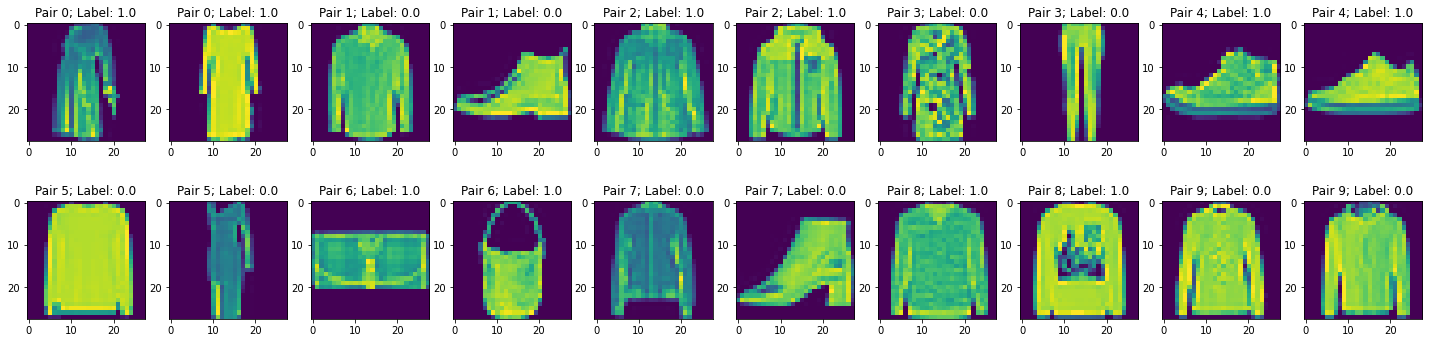

In [4]:
def GetSiameseData(imgs, labels, batch_size):

    image_a = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    image_b = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    label = numpy.zeros(batch_size);
    
    for i in range(batch_size):
        
        if (i % 2 == 0):
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 1
            while (labels[idx1] != labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)            
                
        else:
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 0
            while (labels[idx1] == labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        label[i] = l

    return [image_a, image_b], label

def PairGenerator(imgs, labels, batch_size):
    while True:
        [image_a, image_b], label = GetSiameseData(imgs, labels, batch_size)
        yield [image_a, image_b], label
        
test = PairGenerator(x_train, y_train, 10)
x, y = next(test)

fig = plt.figure(figsize=[25, 6])
for i in range(10):
    ax = fig.add_subplot(2, 10, i*2 + 1)
    ax.imshow(x[0][i,:,:,0])
    ax.set_title('Pair ' + str(i) +'; Label: ' + str(y[i]))
    
    ax = fig.add_subplot(2, 10, i*2 + 2)
    ax.imshow(x[1][i,:,:,0])    
    ax.set_title('Pair ' + str(i) +'; Label: ' + str(y[i]))            

## The Network
You'll get a sense of Deja Vu here too, as we're going to go with a pretty similar setup to last time. At least initially.

Once again, we'll use our VGG functions.

In [5]:
def conv_block(inputs, filters, spatial_dropout = 0.0, max_pool = True):
    
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (spatial_dropout > 0.0):
        x = layers.SpatialDropout2D(spatial_dropout)(x)
    if (max_pool == True):
        x = layers.MaxPool2D(pool_size=(2, 2))(x)
    
    return x

def fc_block(inputs, size, dropout):
    x = layers.Dense(size, activation=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (dropout > 0.0):
        x = layers.Dropout(dropout)(x)
    
    return x

def vgg_net(inputs, filters, fc, spatial_dropout = 0.0, dropout = 0.0):
    
    x = inputs
    for idx,i in enumerate(filters):
        x = conv_block(x, i, spatial_dropout, not (idx==len(filters) - 1))
    
    x = layers.Flatten()(x)
    
    for i in fc:
        x = fc_block(x, i, dropout)
        
    return x

Create the common branch here, as per last time:
* Create an input
* Create the network with our desired parameters
* Add an embedding layer
* Turn that into a model

In [6]:
embedding_size = 32
dummy_input = keras.Input((28, 28, 1))
base_network = vgg_net(dummy_input, [8, 16, 32], [256], 0.2, 0)
embedding_layer = layers.Dense(embedding_size, activation=None)(base_network)
base_network = keras.Model(dummy_input, embedding_layer, name='SiameseBranch')

2022-05-15 05:07:18.429665: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-15 05:07:18.430047: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-15 05:07:18.431136: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


And now we use `base_network` to get our embeddings by:
* creating our two inputs
* passing each of these through the base_network

In [7]:
input_a = keras.Input((28, 28, 1), name='InputA')
input_b = keras.Input((28, 28, 1), name='InputB')

embedding_a = base_network(input_a)
embedding_b = base_network(input_b)

### New Stuff
Something different happens now.

In particular, what we want to do is get the distance between two vectors. We're going to use Euclidean distance, though Cosine distance would also be a valid choice here. Once we've got that, we'll use this distance to drive our contrastive loss.

#### Contrastive Loss

Let's quickly recap the maths here. First up we need to define a distance metric. Here we have the L2 (Euclidean) distance between our two features, $\bar{x}_1$ and $\bar{x}_2$:
$d_i = ||\bar{x}_1 - \bar{x}_2||_2$

We get $\bar{x}_1$ and $\bar{x}_2$ by passing our inputs, $x_1$ and $x_2$, through the base network. Using these, we can then compute our constrastive loss:

$L_{C} = \frac{1}{N}\sum_{i=1}^{N}y_i d_i + (1 - y_i)max(margin - d_i, 0)$

Here, $y_i$ is the label indicating if the two inputs, $x_1$ and $x_2$, belong to the same class. $y_i = 1$ if they belong to the same class. Remember that our network is trained to minimise the loss, so when $y_i = 1$, the second term in our loss, $(1 - y_i)max(margin - d_i, 0)$ goes to 0 and we focus on the first term, $y_i d_i$. Essentially, our network will seek to make $d_i$ as small as possible in these situations such that **if our two inputs are from the same class, the distance between them should be as small**.

When $y_i = 1$, the other term in the loss is active. This term is a little bit stranger to look at, $(1 - y_i)max(margin - d_i, 0)$, but basically what we want is $d_i \geq margin$. If $d_i \geq margin$, then $margin - d_i$ will be less than $0$ and $max(margin - d_i, 0)$ will return $0$. If $d_i < margin$, then we will have a positive loss value here. So this term aims to ensure that **when two inputs are from different classes, the distance between should be at least some value, $margin$**.

#### Implementing Contrastive Loss

Let's implement this now. This has been borrowed from the keras example [here](https://keras.io/examples/mnist_siamese/). 

In [8]:
def euclidean_distance(vects):
    x, y = vects
    x = K.l2_normalize(x, axis=1)
    y = K.l2_normalize(y, axis=1)
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

Now we add a layer to calculate the euclidean distance between the two embeddings, and then build our model

In [9]:
distance = layers.Lambda(euclidean_distance,output_shape=eucl_dist_output_shape)\
                                        ([embedding_a, embedding_b])

siamese_network = keras.Model([input_a, input_b], distance)
keras.utils.plot_model(siamese_network, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [10]:
siamese_network.compile(loss=contrastive_loss, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

Training and testing setup is as per the last example.

In [11]:
batch_size = 128
training_gen = PairGenerator(x_train, y_train, batch_size)

siamese_test_x, siamese_test_y = GetSiameseData(x_test, y_test, 10000)

siamese_network.fit(training_gen, steps_per_epoch = 60000 // batch_size, epochs=10, validation_data = (siamese_test_x, siamese_test_y))

2022-05-15 05:07:20.475008: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-15 05:07:20.475704: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2095985000 Hz


Epoch 1/10
  5/468 [..............................] - ETA: 6:20 - loss: 0.5871 - accuracy: 0.4996

KeyboardInterrupt: 

# The Results
Let's have a look at some outputs.

We'll start with just a random 10 samples and see what it returns. For extra info, we'll plot the raw score out of the network rather than the rounded result, and show the expected score in brackets.

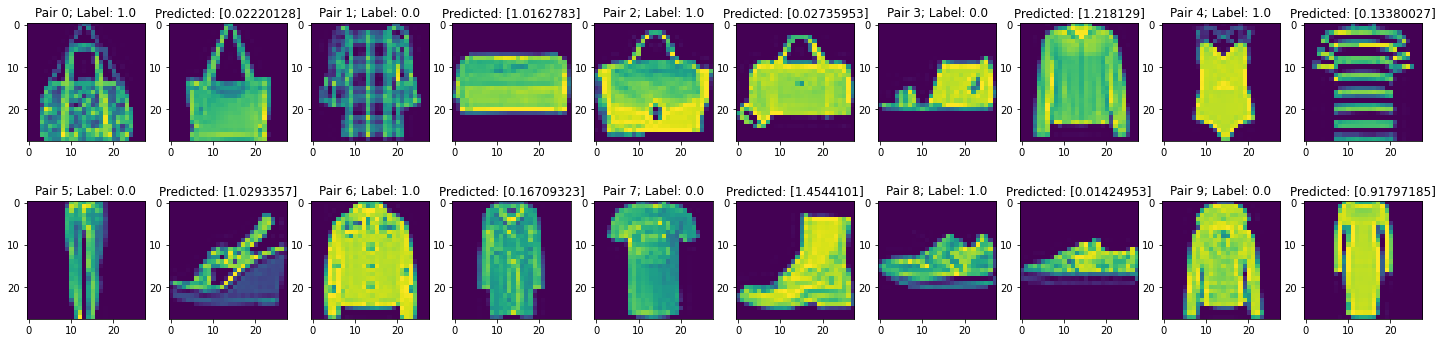

In [ ]:
x, y = GetSiameseData(x_test, y_test, 10)
res = siamese_network.predict(x)

fig = plt.figure(figsize=[25, 6])
for i in range(10):
    ax = fig.add_subplot(2, 10, i*2 + 1)
    ax.imshow(x[0][i,:,:,0])
    ax.set_title('Pair ' + str(i) +'; Label: ' + str(y[i]))
    
    ax = fig.add_subplot(2, 10, i*2 + 2)
    ax.imshow(x[1][i,:,:,0])    
    ax.set_title('Predicted: ' + str(res[i]))

These results look, on the whole, pretty good. Similar objects are close, dissimilar objects are far away. But all is not perfect. Consider the second and fifth pairs - where the dissimilar pair (pair 1) are closer than the similar pair (pair 4).

Looking at things with a constant first image we get this:

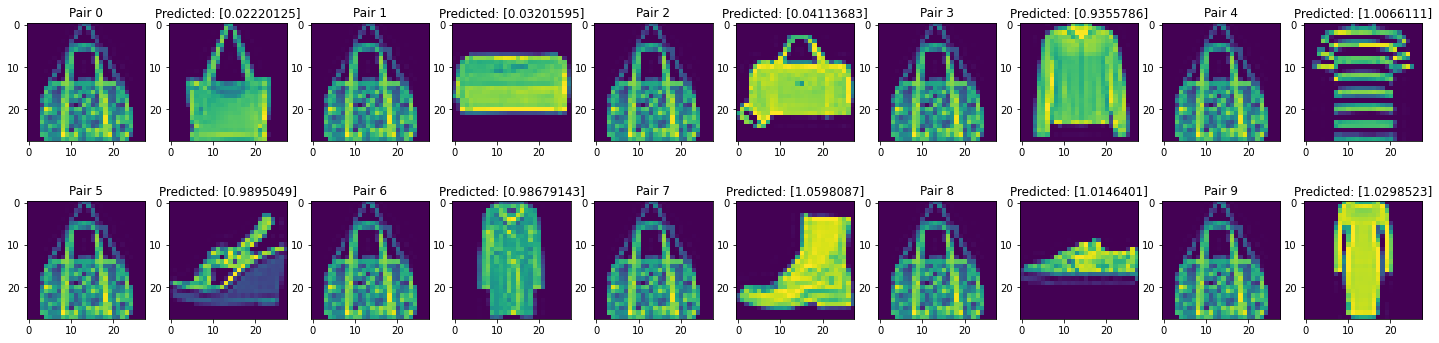

In [ ]:
for i in range(10):
    x[0][i,:] = x[0][0,:]

res = siamese_network.predict(x)

fig = plt.figure(figsize=[25, 6])
for i in range(10):
    ax = fig.add_subplot(2, 10, i*2 + 1)
    ax.imshow(x[0][i,:,:,0])
    ax.set_title('Pair ' + str(i))
    
    ax = fig.add_subplot(2, 10, i*2 + 2)
    ax.imshow(x[1][i,:,:,0])    
    ax.set_title('Predicted: ' + str(res[i]))

This looks ok, but it's hard to determine which is more similar of a shoe and a jumper.
If we look at the distributions of the scores we get an idea of what's going on.

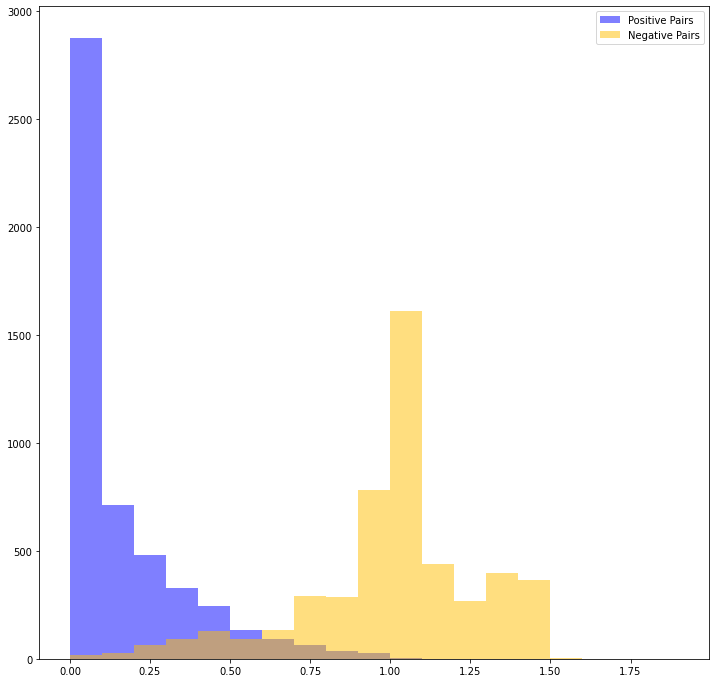

In [ ]:
pred = siamese_network.predict(siamese_test_x)
positive_distances = pred[siamese_test_y == 1]
negative_distances = pred[siamese_test_y == 0]
fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(1, 1, 1)
ax.hist(positive_distances, numpy.arange(0, 2.0, 0.1), label='Positive Pairs', fc=(0, 0, 1.0, 0.5))
ax.hist(negative_distances, numpy.arange(0, 2.0, 0.1), label='Negative Pairs', fc=(1.0, 0.75, 0, 0.5))
ax.legend();

We can see that, in general, there's a good bit of separation there, but there is also lots of overlap which leads to some of these errors. Ideally, we'd like to get these two distributions further apart, and minimise that overlap as much as possible.

Finally, we'll look at the embeddings.

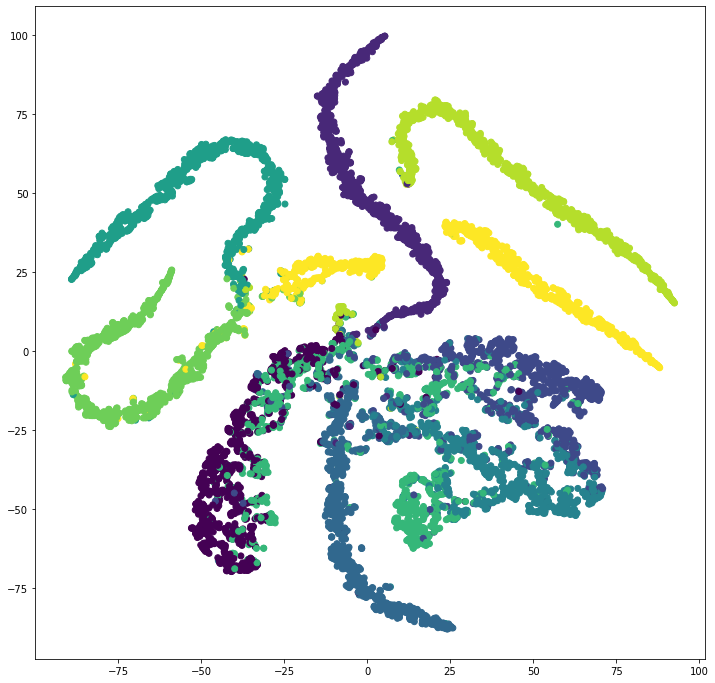

In [ ]:
embeddings = base_network.predict(x_test)
tsne_embeddings = TSNE(random_state=4).fit_transform(embeddings)
fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = y_test.flatten());

This looks much better than what we had with a binary cross entropy loss. While there is still confusion, on the whole there is much better separation going on.

## Final Thoughts
In this example we've used contrastive loss to train our siamese network. Compared to binary cross entropy this means that:
* We don't need a subnetwork, we just train our main brach and try to control how the embedding is generated
* The output of our network is an embedding, which we can compare to the embeddings from other images, letting us work out how similar two things are

There are of course some caveats to all that:
* "Similar" is to some extent whatever the network decides, we don't directly control that as all we give the network is information as to whether the pairs are of the same class or different classes. There is not much nuance in the distances that we feed the network.
* We don't get great separation between distributions that capture the distance between things of the same class, and things of a different class; so the method does still make plenty of errors.

So why would we use this over binary cross entropy? It's simpler for one thing. We just have our base network and loss works directly with that, there is no need to learn a classifier. It also offers flexibility in that it can be used for ranking items based on similarity (even if it's perhaps not amazing at that). For retrieval tasks, where we want to find, for example, all faces like that of a person of interest, this sort of method is much more useful than binary cross entropy - which only tells us if two things are the same.

That said, there are issues with the fact that we need to specify the margin (though we have pretty much mittigated that by using normalisation), and that the network never has to try and pull similar subjects towards each other at the same time as it has to push different subjects apart.